In [1]:
import os
import sys
import glob
import cv2
from icecream import ic
import random
import numpy as np
import pandas as pd
# from tqdm.notebook import tqdm, trange
from tqdm.auto import tqdm
from PIL import Image  
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

## set the seed of the random number generator to a fixed value, the results will be reproducible.


In [2]:
# set the seed of the random number generator to a fixed value, the results will be reproducible.
SEED = 2
def set_seed(SEED):
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)  # for generating random numbers
    torch.cuda.manual_seed(SEED)  # for generating random numbers for the current GPU
    torch.cuda.manual_seed_all(SEED)  # for generating random numbers on all GPUs
    # cudnn.deterministic: CuDNN algorithms are deterministic
    # get the same result if run the same CuDNN-ops with the same inputs on the same system
    torch.backends.cudnn.deterministic = True
    # cudnn.benchmark is good whenever input sizes for the network do not vary 
    # cudnn look for the optimal set of algorithms for that particular configuration. This leads to faster runtime.
    torch.backends.cudnn.benchmark = False
set_seed(SEED)

# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

## train_data preparation

In [3]:
root_directory = sys.path[0]
file_path = os.path.join(root_directory, 'data_YOLO', 'bbox_image')
train_data = pd.DataFrame({})


def all_file(x):
    i_n = os.path.basename(x)
    img_name, _ = os.path.splitext(i_n)
    img_id = img_name.split('_',1)[1]
    return img_id

def get_shape(x):
    im = Image.open(x)
    img_size = im.size
    return img_size

train_data['all_file'] = glob.glob(os.path.join(file_path, '*'))
train_data['image_id'] = train_data['all_file'].apply(lambda x: all_file(x))
train_data['width'] = train_data['all_file'].apply(lambda x: get_shape(x)[0])
train_data['height'] = train_data['all_file'].apply(lambda x: get_shape(x)[1])
resize_width = int(train_data.width.mean())
resize_height = int(train_data.height.mean())
train_data

,all_file,image_id,width,height
0,/Users/schnappiiii/Applied_Machine_Intelligenc...,7058255,158,117
1,/Users/schnappiiii/Applied_Machine_Intelligenc...,7070386_2,173,149
2,/Users/schnappiiii/Applied_Machine_Intelligenc...,7034932,548,542
3,/Users/schnappiiii/Applied_Machine_Intelligenc...,7065194,562,696
4,/Users/schnappiiii/Applied_Machine_Intelligenc...,7071587,221,92
...,...,...,...,...
892,/Users/schnappiiii/Applied_Machine_Intelligenc...,7072279,42,38
893,/Users/schnappiiii/Applied_Machine_Intelligenc...,7031498,465,624
894,/Users/schnappiiii/Applied_Machine_Intelligenc...,7035064,209,141
895,/Users/schnappiiii/Applied_Machine_Intelligenc...,7058807,39,50


In [4]:
batch_size = 64
learning_rate = 0.005
epochs = 10

## build dataset class for dataloader

In [5]:
class bbox_dataset(Dataset):
    def __init__(self, train_data):
        self.train_data = train_data
        self.tensor_transform = T.Compose([T.Resize([resize_width, resize_height], interpolation=T.InterpolationMode.BICUBIC), \
            # T.Grayscale(num_output_channels=1), \
            T.ToTensor()])
        self.normalize_transform = T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    def __len__(self):       
        return self.train_data.shape[0]

    def __getitem__(self, idx):
        fp  = self.train_data.all_file.tolist()[idx]
        img = Image.open(fp)
        original_img = self.tensor_transform(img)
        input = self.normalize_transform(original_img)
        
        sample = dict()
        sample['original_img'] = original_img
        sample['input'] = input
        sample['image_id'] = train_data.iloc[idx,:].image_id
        return sample

train_dataset = bbox_dataset(train_data)
print(len(train_dataset))
train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size)  # , num_workers=2

897


## sample some resized images in dataloader

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


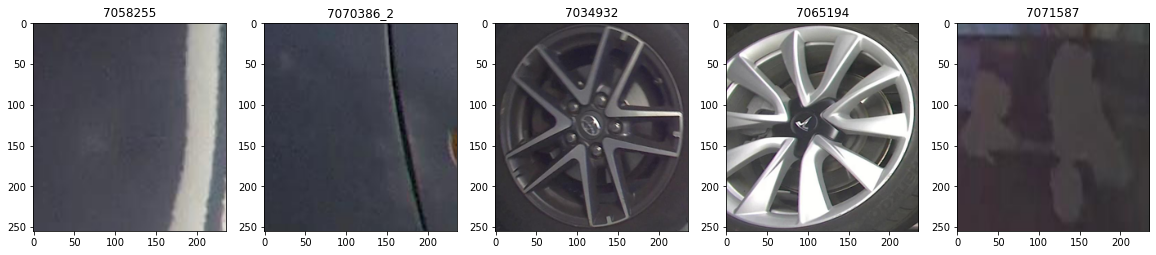

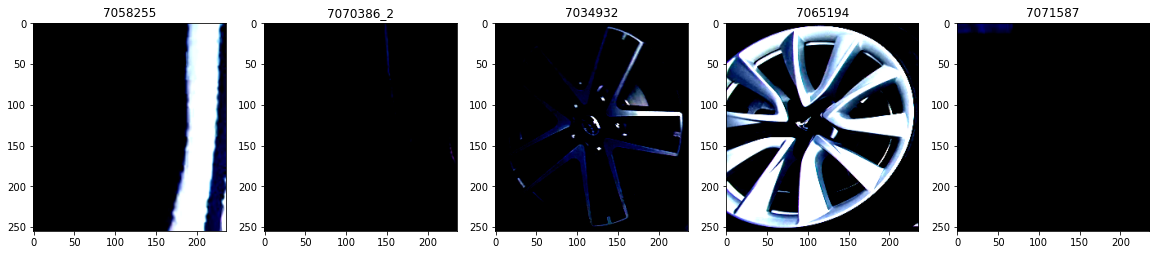

In [6]:
# iter(): returns an iterator, next(): returns the next item from the iterator
sample = next(iter(train_dataloader))

fig, ax = plt.subplots(1, 5, figsize=(20, 10))
for i in range(5):
    ax[i].imshow(sample['original_img'][i].permute(1, 2, 0))
    ax[i].set_title(sample['image_id'][i])

fig, ax = plt.subplots(1, 5, figsize=(20, 10))
for i in range(5):
    ax[i].imshow(sample['input'][i].permute(1, 2, 0))
    ax[i].set_title(sample['image_id'][i])

## build model

In [7]:
class AutoEncoder(nn.Module):
    def __init__(self, resize_width, resize_height):
        super(AutoEncoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(resize_width*resize_height, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 4),
        )
        self.decoder = nn.Sequential(
            nn.Linear(4, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, resize_width*resize_height),  
            nn.Sigmoid()  # compress to a range (0, 1)
        )

    def forward(self, x):
      encoded = self.encoder(x)
      decoded = self.decoder(encoded)
      return encoded, decoded

autoencoder = AutoEncoder(resize_width, resize_height).to(device)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=learning_rate)
criterion = nn.MSELoss().to(device)

## train

In [8]:
for epoch in tqdm(range(epochs)):
    for step, sample in enumerate(train_dataloader):
        input = sample['input'].float().to(device)
        input = input.view(-1, resize_width*resize_height)
        encoded, decoded = autoencoder(input)

        loss = criterion(decoded, input)
        optimizer.zero_grad()                   # clear gradients for this training step
        loss.backward()                         # backpropagation, compute gradients
        optimizer.step()   

        if step % 2 == 0:
            print('Epoch: ', epoch+1, 'train loss: %.4f' % loss)
    # print('Epoch: ', epoch+1, 'train loss: %.4f' % loss)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch:  1 train loss: 2.0460
Epoch:  1 train loss: 1.6557
Epoch:  1 train loss: 1.2194
Epoch:  1 train loss: 1.0227
Epoch:  1 train loss: 1.1186
Epoch:  1 train loss: 1.0286
Epoch:  1 train loss: 1.1612


 10%|█         | 1/10 [00:08<01:17,  8.58s/it]

Epoch:  1 train loss: 0.2262
Epoch:  2 train loss: 1.2586
Epoch:  2 train loss: 1.3413
Epoch:  2 train loss: 1.0952
Epoch:  2 train loss: 0.9928
Epoch:  2 train loss: 1.1086
Epoch:  2 train loss: 1.0186
Epoch:  2 train loss: 1.1423


 20%|██        | 2/10 [00:16<01:07,  8.42s/it]

Epoch:  2 train loss: 0.2508
Epoch:  3 train loss: 1.2396
Epoch:  3 train loss: 1.3107
Epoch:  3 train loss: 1.0709
Epoch:  3 train loss: 0.9844
Epoch:  3 train loss: 1.1077
Epoch:  3 train loss: 1.0032
Epoch:  3 train loss: 1.1094


 30%|███       | 3/10 [00:25<00:59,  8.43s/it]

Epoch:  3 train loss: 0.3295
Epoch:  4 train loss: 1.2189
Epoch:  4 train loss: 1.2850
Epoch:  4 train loss: 1.0524
Epoch:  4 train loss: 0.9904
Epoch:  4 train loss: 1.0981
Epoch:  4 train loss: 1.0095
Epoch:  4 train loss: 1.1001


 40%|████      | 4/10 [00:33<00:50,  8.43s/it]

Epoch:  4 train loss: 0.3458
Epoch:  5 train loss: 1.2046
Epoch:  5 train loss: 1.2594
Epoch:  5 train loss: 1.0425
Epoch:  5 train loss: 0.9884
Epoch:  5 train loss: 1.0998
Epoch:  5 train loss: 1.0022
Epoch:  5 train loss: 1.0908


 50%|█████     | 5/10 [00:42<00:42,  8.43s/it]

Epoch:  5 train loss: 0.3679
Epoch:  6 train loss: 1.2024
Epoch:  6 train loss: 1.2540
Epoch:  6 train loss: 1.0384
Epoch:  6 train loss: 0.9883
Epoch:  6 train loss: 1.0972
Epoch:  6 train loss: 1.0022
Epoch:  6 train loss: 1.0844


 60%|██████    | 6/10 [00:50<00:33,  8.40s/it]

Epoch:  6 train loss: 0.3805
Epoch:  7 train loss: 1.1968
Epoch:  7 train loss: 1.2561
Epoch:  7 train loss: 1.0374
Epoch:  7 train loss: 0.9917
Epoch:  7 train loss: 1.0988
Epoch:  7 train loss: 1.0000
Epoch:  7 train loss: 1.0836


 70%|███████   | 7/10 [00:58<00:25,  8.34s/it]

Epoch:  7 train loss: 0.3910
Epoch:  8 train loss: 1.1946
Epoch:  8 train loss: 1.2531
Epoch:  8 train loss: 1.0371
Epoch:  8 train loss: 0.9985
Epoch:  8 train loss: 1.1013
Epoch:  8 train loss: 1.0031
Epoch:  8 train loss: 1.0836


 80%|████████  | 8/10 [01:06<00:16,  8.31s/it]

Epoch:  8 train loss: 0.3981
Epoch:  9 train loss: 1.2003
Epoch:  9 train loss: 1.2548
Epoch:  9 train loss: 1.0434
Epoch:  9 train loss: 0.9971
Epoch:  9 train loss: 1.0998
Epoch:  9 train loss: 1.0075
Epoch:  9 train loss: 1.0851


 90%|█████████ | 9/10 [01:15<00:08,  8.28s/it]

Epoch:  9 train loss: 0.3980
Epoch:  10 train loss: 1.2031
Epoch:  10 train loss: 1.2532
Epoch:  10 train loss: 1.0371
Epoch:  10 train loss: 0.9928
Epoch:  10 train loss: 1.0977
Epoch:  10 train loss: 1.0104
Epoch:  10 train loss: 1.0741


100%|██████████| 10/10 [01:23<00:00,  8.34s/it]

Epoch:  10 train loss: 0.3400


## generate labels for all annotated images

In [9]:
class_list =[]
for i in train_data.iloc[:,0]:
    # im = Image.open(i)
    im = cv2.imread(i)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    # im = cv2.resize(im,(resize_width,resize_height))
    im.resize(resize_width,resize_height,3)

    b = torch.from_numpy(im)/255.  # to tensor
    b = b.view(-1, resize_width*resize_height).to(device)
    encoded_data, _ = autoencoder(b)
    tmp = torch.sum(encoded_data,dim=0)
#     m = nn.Softmax()
#     tmp = m(tmp)
    class_ = torch.argmax(tmp)
    class_list.append(class_.item())
    
train_data['class'] = class_list
train_data

,all_file,image_id,width,height,class
0,/Users/schnappiiii/Applied_Machine_Intelligenc...,7058255,158,117,2
1,/Users/schnappiiii/Applied_Machine_Intelligenc...,7070386_2,173,149,2
2,/Users/schnappiiii/Applied_Machine_Intelligenc...,7034932,548,542,2
3,/Users/schnappiiii/Applied_Machine_Intelligenc...,7065194,562,696,2
4,/Users/schnappiiii/Applied_Machine_Intelligenc...,7071587,221,92,2
...,...,...,...,...,...
892,/Users/schnappiiii/Applied_Machine_Intelligenc...,7072279,42,38,2
893,/Users/schnappiiii/Applied_Machine_Intelligenc...,7031498,465,624,2
894,/Users/schnappiiii/Applied_Machine_Intelligenc...,7035064,209,141,1
895,/Users/schnappiiii/Applied_Machine_Intelligenc...,7058807,39,50,2


In [10]:

# transform_ = T.Compose([T.Resize([resize_width, resize_height], interpolation=T.InterpolationMode.BICUBIC),
#     transforms.ToTensor(),
#     T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# # img_tr = transform_(img)
# # img_np = np.array(img_tr)

# class_list =[]
# for i in train_data.iloc[:,0]:
#     im = Image.open(i)
#     # im = cv2.imread(i)
#     # im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
#     # im = cv2.resize(im,(resize_width,resize_height))
#     # im.resize(resize_width,resize_height,3)
#     im = transform_(im)

#     # b = torch.from_numpy(im)/255.  # to tensor
#     b = b.view(-1, resize_width*resize_height).to(device)
#     encoded_data, _ = autoencoder(b)
#     tmp = torch.sum(encoded_data,dim=0)
# #     m = nn.Softmax()
# #     tmp = m(tmp)
#     class_ = torch.argmax(tmp)
#     class_list.append(class_.item())
    
# train_data['class'] = class_list
# train_data

In [11]:
# class_list =[]
# for i in train_data.iloc[:,0]:
#     im = cv2.imread(i)
#     im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

#     im.resize(resize_width,resize_height,3)
#     b = torch.from_numpy(im)/255.  # to tensor
#     b = b.view(-1, resize_width*resize_height).to(device)
#     encoded_data, _ = autoencoder(b)
#     tmp = torch.sum(encoded_data,dim=0)

#     # class_ = torch.argmax(tmp)
#     m = nn.Softmax()
#     class_ = m(tmp)
#     class_ = torch.argmax(class_)
#     class_list.append(class_.item())
    
# train_data['class'] = class_list
# train_data

## smaple some images and their labels

True


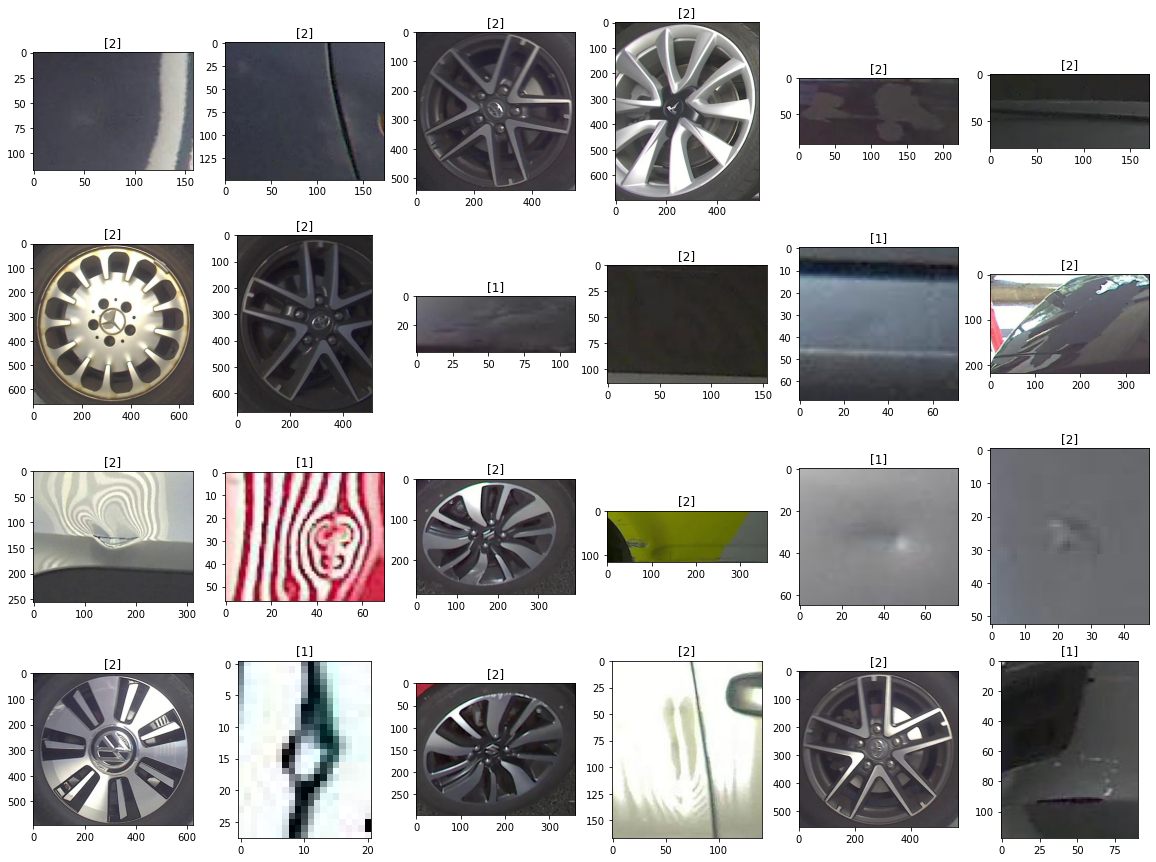

In [12]:
classes = {0:'dent', 1:'rim', 2:'other', 3:'scratch'}  # 0,1,3 wrong
print(train_data['class'].isin([1]).any())

count = 0
rows = 4
cols = 6
fig, ax = plt.subplots(rows, cols, figsize=(20, 15))
for i in range(rows):
    for j in range(cols):
        n = train_data.iloc[count,0]
        a = Image.open(n)
        ax[i][j].imshow(a)
        ax[i][j].set_title(train_data.loc[count,['class']].values)
        count +=1

tensor([[-5.7327e+01,  4.0540e+01,  4.0512e+01,  3.5566e+01],
        [ 4.4188e-01,  4.7516e-02, -6.0581e-01, -2.1613e-01],
        [ 4.4188e-01,  4.7516e-02, -6.0581e-01, -2.1613e-01]],
       grad_fn=<AddmmBackward0>)


/Users/schnappiiii/opt/anaconda3/envs/pytorch_python37/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  """


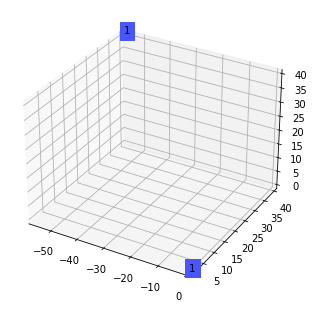

In [13]:
# visualize in 3D plot
# view_data = train_data.train_data[:200].view(-1, 28*28).type(torch.FloatTensor)/255.
# encoded_data, _ = autoencoder(view_data)
fig = plt.figure(2)
ax = Axes3D(fig)
a=encoded_data.data[:, 0].cpu()
print(encoded_data)
X, Y, Z = encoded_data.data[:, 0].cpu(), encoded_data.data[:, 1].cpu(), encoded_data.data[:, 2].cpu()
# values = train_data.train_labels[:200].numpy()
for x, y, z in zip(X, Y, Z):
    c = cm.rainbow(int(255/9))
    ax.text(x, y, z, '1', backgroundcolor=c)
ax.set_xlim(X.min(), X.max())
ax.set_ylim(Y.min(), Y.max())
ax.set_zlim(Z.min(), Z.max())
plt.show()

## Remove Decoder and Add Classifier layer

In [14]:
new_classifier = nn.Sequential(*list(autoencoder.children())[:-1])
net = new_classifier
net.add_module('classifier', nn.Sequential(nn.Linear(16, 4), nn.LogSoftmax(dim=1)))
net = net.to(device)
print(net)

    
weights = copy.deepcopy(net[0][0].weight.data)
init_classifier_weights = copy.deepcopy(net.classifier[0].weight.data)

Sequential(
  (0): Sequential(
    (0): Linear(in_features=60180, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=12, bias=True)
    (5): ReLU()
    (6): Linear(in_features=12, out_features=4, bias=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=16, out_features=4, bias=True)
    (1): LogSoftmax(dim=1)
  )
)
